**Importing Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.layers import Layer, Conv2D, ReLU, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Creating Custom Dataset**

In [2]:
class BreastCancerDataset(tf.keras.utils.Sequence):
    def __init__(self, root_dir, image_size=(256, 256)):
        self.root_dir = root_dir
        self.image_size = image_size
        self.image_files = []
        self.mask_files = []

        for label in ["benign", "malignant", "normal"]:
            img_folder = os.path.join(root_dir, label)
            for file in os.listdir(img_folder):
                if "_mask" not in file:
                    self.image_files.append(os.path.join(img_folder, file))
                    self.mask_files.append(os.path.join(img_folder, file.replace(".png", "_mask.png")))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = load_img(img_path, target_size=self.image_size)
        image = img_to_array(image) / 255.0  # Normalize to [0, 1]

        mask = load_img(mask_path, color_mode="grayscale", target_size=self.image_size)
        mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]

        return image, mask

**Mounting Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**Preprocessing Dataset**

In [4]:
dataset_path = '/content/drive/MyDrive/CVPR/Dataset_BUSI_with_GT'
dataset = BreastCancerDataset(root_dir=dataset_path)

# Split into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    dataset.image_files, dataset.mask_files, test_size=0.2, random_state=42
)

def preprocess(image_path, mask_path, image_size=(256, 256)):
    image = load_img(image_path, target_size=image_size)
    image = img_to_array(image) / 255.0

    mask = load_img(mask_path, color_mode="grayscale", target_size=image_size)
    mask = img_to_array(mask) / 255.0

    return image, mask

# Create TensorFlow datasets
def load_data(image_paths, mask_paths):
    images = []
    masks = []
    for img, mask in zip(image_paths, mask_paths):
        image, mask = preprocess(img, mask)
        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

train_images, train_masks = load_data(train_images, train_masks)
val_images, val_masks = load_data(val_images, val_masks)

**Averaging Custom Spatial**

In [5]:
class SpatialAverageLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=3, keepdims=True)


**Initializing Dual Attention Mechanism**

In [6]:
class DualAttentionModule(Layer):
    def __init__(self, in_channels):
        super(DualAttentionModule, self).__init__()
        self.channel_avg_pool = GlobalAveragePooling2D()
        self.channel_dense = Conv2D(in_channels, kernel_size=1, activation='sigmoid')
        self.spatial_avg = SpatialAverageLayer()
        self.spatial_conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        # Channel attention
        channel_avg = tf.expand_dims(self.channel_avg_pool(inputs), axis=1)
        channel_avg = tf.expand_dims(channel_avg, axis=1)
        channel_dense = self.channel_dense(channel_avg)
        channel_attention = inputs * channel_dense

        # Spatial attention
        spatial_avg = self.spatial_avg(inputs)
        spatial_attention = inputs * self.spatial_conv(spatial_avg)

        return channel_attention + spatial_attention


**Initializing Convolutional Block**

In [7]:
class ConvBlock(Layer):
    def __init__(self, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv2D(out_channels, kernel_size=3, padding='same')
        self.conv2 = Conv2D(out_channels, kernel_size=3, padding='same')
        self.relu = ReLU()

    def call(self, inputs):
        x = self.relu(self.conv1(inputs))
        x = self.relu(self.conv2(x))
        return x



**Modeling Enhanced U-Net++**

In [8]:
class EnhancedUNetPlusPlus(Model):
    def __init__(self, input_channels=3, num_classes=1):
        super(EnhancedUNetPlusPlus, self).__init__()
        self.enc1 = ConvBlock(64)
        self.enc2 = ConvBlock(128)
        self.enc3 = ConvBlock(256)
        self.enc4 = ConvBlock(512)
        self.bottleneck = ConvBlock(1024)
        self.dual_attention = DualAttentionModule(1024)
        self.up4 = Conv2DTranspose(512, kernel_size=2, strides=2)
        self.dec4 = ConvBlock(512)
        self.up3 = Conv2DTranspose(256, kernel_size=2, strides=2)
        self.dec3 = ConvBlock(256)
        self.up2 = Conv2DTranspose(128, kernel_size=2, strides=2)
        self.dec2 = ConvBlock(128)
        self.up1 = Conv2DTranspose(64, kernel_size=2, strides=2)
        self.dec1 = ConvBlock(64)
        self.output_layer = Conv2D(num_classes, kernel_size=1, activation='sigmoid')

    def call(self, inputs):
        # Encoder
        c1 = self.enc1(inputs)
        p1 = tf.nn.max_pool2d(c1, ksize=2, strides=2, padding='SAME')
        c2 = self.enc2(p1)
        p2 = tf.nn.max_pool2d(c2, ksize=2, strides=2, padding='SAME')
        c3 = self.enc3(p2)
        p3 = tf.nn.max_pool2d(c3, ksize=2, strides=2, padding='SAME')
        c4 = self.enc4(p3)
        p4 = tf.nn.max_pool2d(c4, ksize=2, strides=2, padding='SAME')

        # Bottleneck
        bn = self.bottleneck(p4)
        bn = self.dual_attention(bn)

        # Decoder
        u4 = self.up4(bn)
        d4 = self.dec4(tf.concat([u4, c4], axis=-1))
        u3 = self.up3(d4)
        d3 = self.dec3(tf.concat([u3, c3], axis=-1))
        u2 = self.up2(d3)
        d2 = self.dec2(tf.concat([u2, c2], axis=-1))
        u1 = self.up1(d2)
        d1 = self.dec1(tf.concat([u1, c1], axis=-1))

        return self.output_layer(d1)

**Training Model**

In [9]:
# Instantiate model
model = EnhancedUNetPlusPlus(input_channels=3, num_classes=1)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Train model
history = model.fit(
    x=train_images,
    y=train_masks,
    validation_data=(val_images, val_masks),
    epochs=50,
    batch_size=8
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 134s 976ms/step - accuracy: 0.9254 - loss: 0.4929 - val_accuracy: 0.9183 - val_loss: 0.2907
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 541ms/step - accuracy: 0.9196 - loss: 0.2749 - val_accuracy: 0.9183 - val_loss: 0.2412
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 82s 537ms/step - accuracy: 0.9191 - loss: 0.2319 - val_accuracy: 0.9183 - val_loss: 0.2196
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - accuracy: 0.9191 - loss: 0.2180 - val_accuracy: 0.9183 - val_loss: 0.2394
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 525ms/step - accuracy: 0.9280 - loss: 0.1982 - val_accuracy: 0.9183 - val_loss: 0.2176
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 83s 541ms/step - accuracy: 0.9259 - loss: 0.1988 - val_accuracy: 0.9233 - val_loss: 0.2163
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 519ms/step - accuracy: 0.9265 - loss: 0.2007 - val_accuracy: 0.9265 - val_loss: 0.2049
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 527ms/step - accuracy: 0.9348 - loss: 0.1808 - val_acc

**Evaluating Model**

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9610 - loss: 0.2367
Validation Loss: 0.2500203847885132, Validation Accuracy: 0.9572893977165222
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


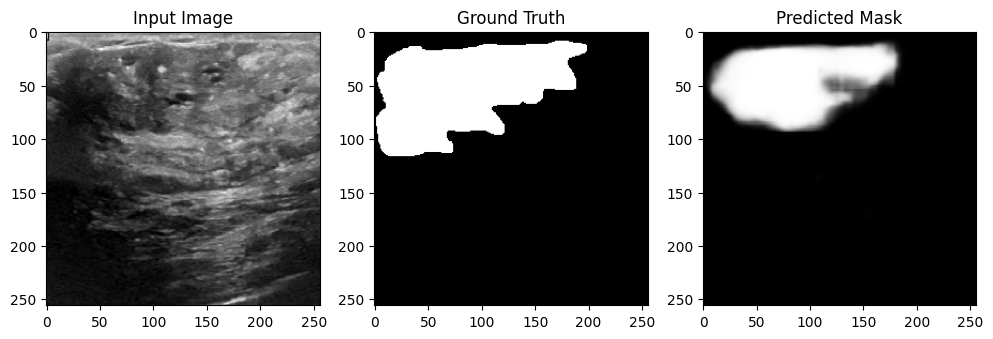

In [10]:
# Evaluate model
loss, accuracy = model.evaluate(val_images, val_masks, batch_size=8)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Visualize predictions
sample_image = val_images[0]
sample_mask = val_masks[0]
predicted_mask = model.predict(sample_image[np.newaxis, ...])[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(sample_image)

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(sample_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.show()


**Plotting Accuracy**

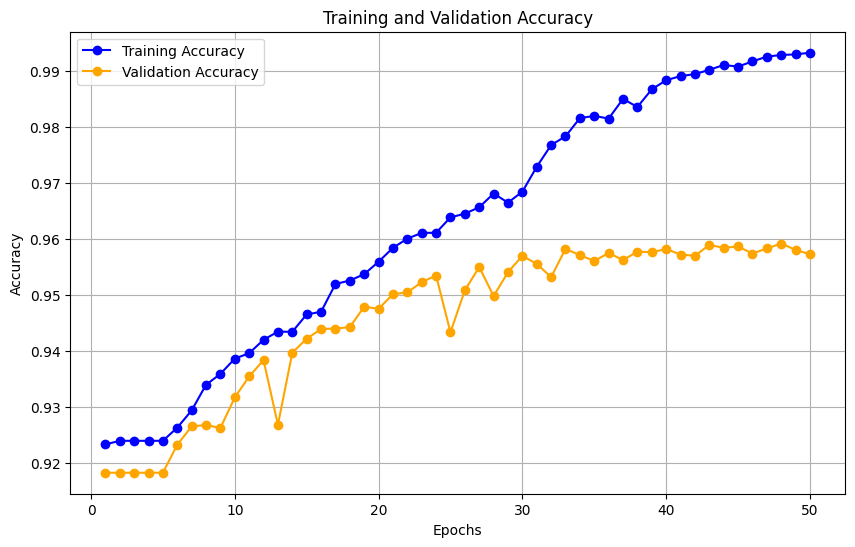

In [11]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Plotting Loss**

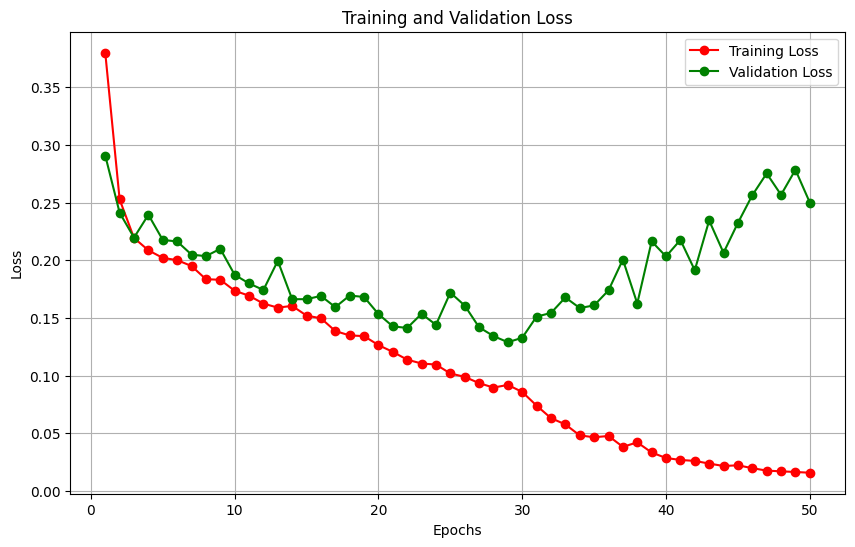

In [12]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Visualizing Validation Result**

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9610 - loss: 0.2367
Validation Loss: 0.2500203847885132, Validation Accuracy: 0.9572893977165222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


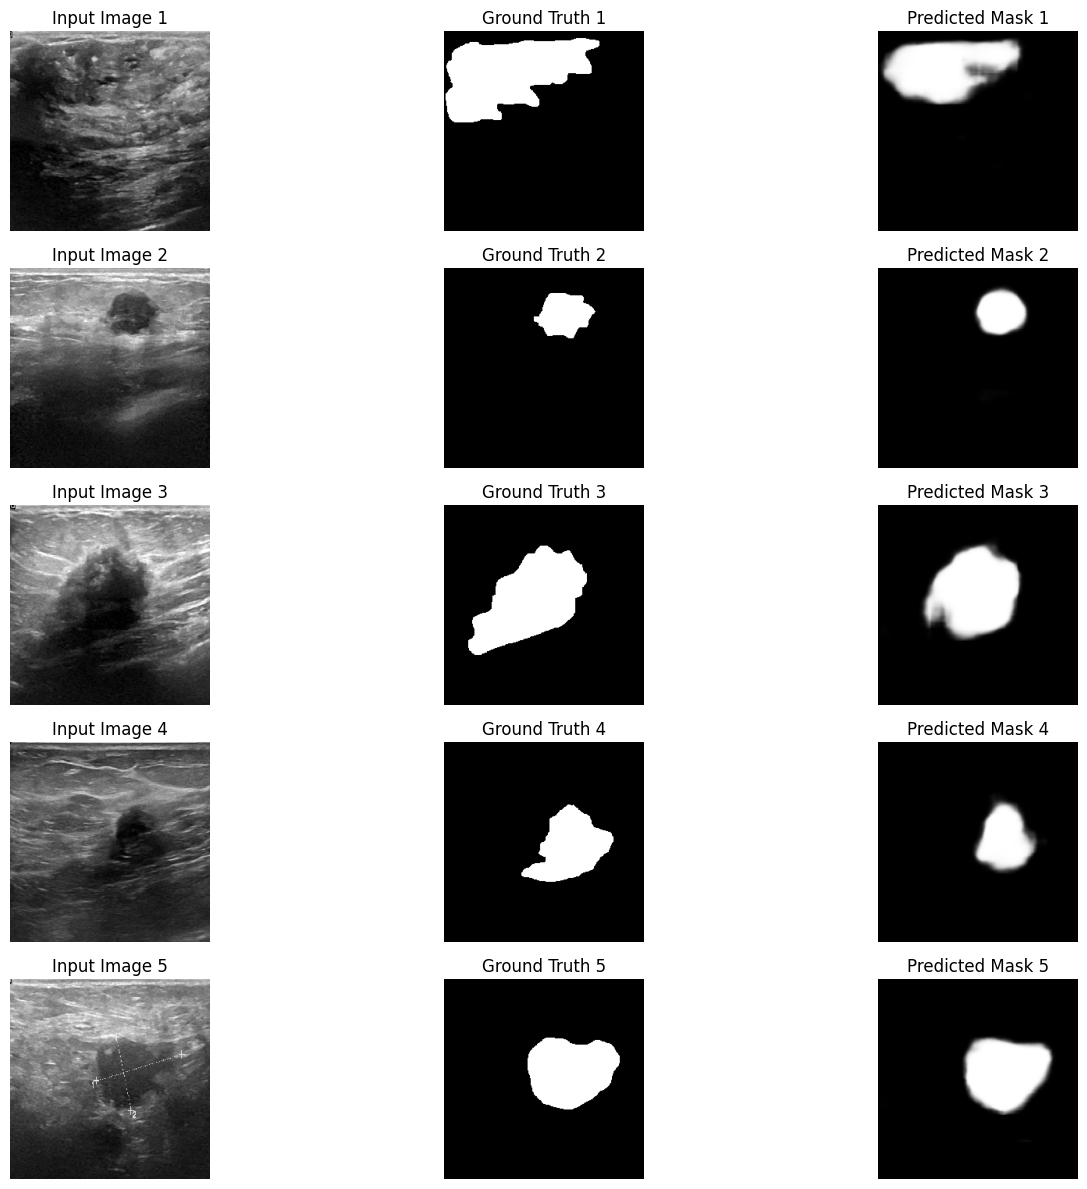

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate model on validation data
loss, accuracy = model.evaluate(val_images, val_masks, batch_size=8)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Select 5 sample images from validation set
num_samples = 5
sample_images = val_images[:num_samples]
sample_masks = val_masks[:num_samples]

# Plot the results for 5 images
plt.figure(figsize=(15, 12))

for i in range(num_samples):
    sample_image = sample_images[i]
    sample_mask = sample_masks[i]
    predicted_mask = model.predict(sample_image[np.newaxis, ...])[0]

    plt.subplot(num_samples, 3, i*3 + 1)
    plt.title(f"Input Image {i+1}")
    plt.imshow(sample_image)
    plt.axis('off')

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.title(f"Ground Truth {i+1}")
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.title(f"Predicted Mask {i+1}")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
